In [3]:
import json
import os
import csv
import re
from os import walk

import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf       # for ANOVA
import statsmodels.stats.multicomp as multi # for post hoc test 
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing
import scipy.spatial.distance as distance
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import skew
from pyquaternion import Quaternion
from matplotlib.backends.backend_pdf import PdfPages

from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
import math
import sys
import subprocess

# Import analysis Scripts
# import nbimporter
# import Analysis_Util as analysis_util


pd.set_option('display.max_columns', None)  
sns.set()

/Users/jeremyhartmann/anaconda/envs/AEAnalysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data cleaning

In [19]:
datapath = r"/Volumes/Second_HD/GIT_DIR_2/Fabric-Hyperledger-OCERT-Project/data/"
distalfile = r"/Volumes/Second_HD/GIT_DIR_2/Fabric-Hyperledger-OCERT-Project/data/distal_all.csv"

In [5]:
f = []
for (dirpath, dirnames, filenames) in walk(datafile):
    f.extend(filenames)
    break

In [51]:
splitLine[1][:-2]

'20.614063597'

In [88]:
header = "FunctionType, TotalTime, SecurityParam, Iteration\n"
opfile = open(distalfile, 'a')
opfile.write(header)

for file in os.listdir(datapath):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        fullfilename = datapath + filename
        shortname = filename[:-4]
        splitFileName = shortname.split("Log")
        
        dataType = splitFileName[0]
        securityparam = splitFileName[1]
        
        # Iterate over lines
        with open(fullfilename) as f:
            sequence = 0
            for line in f:
                splitLine = line.split(': ')
                
                time = 0.0
                if splitLine[1][-3:-1] == "ms":
                    time = float(splitLine[1][:-3])
                else:
                    time = float(splitLine[1][:-2]) * 1000
                
                line = "{},{},{},{}\n".format(dataType, time, securityparam, sequence)
                opfile.write(line)
                sequence = sequence + 1
            



opfile.close()


# Load data

In [113]:
alldata = pd.read_csv("../Analysis/result_2.csv", skipinitialspace=True)

In [114]:
pivotdata = alldata.pivot("Sequence", "Function")
pivotdata = pivotdata.reset_index(drop=True)

# Convert to non multi-level index
pivotdata.columns = pivotdata.columns.droplevel(0)

In [115]:
# Add verify columnb
pivotdata["Verify"] = pivotdata.VerifyProof - pivotdata.Proof
pivotdata["Sequence"] = pivotdata.index

In [116]:
# Melt the data
meltdata = pd.melt(pivotdata, id_vars=["Sequence"])
meltdata = meltdata.reset_index()

# Data Analysis

In [125]:
pivotdata.describe()

Function,Proof,VerifyProof,Verify,Sequence
count,100.000000,100.000000,100.000000,100.000000
mean,1.089218,2.455485,1.366267,49.500000
std,0.190403,0.243804,0.331706,29.011492
min,0.812312,2.072331,0.521617,0.000000
25%,0.957181,2.263430,1.173422,24.750000
50%,1.057255,2.429312,1.355135,49.500000
75%,1.185050,2.576702,1.584384,74.250000
max,1.727037,3.438067,2.479897,99.000000


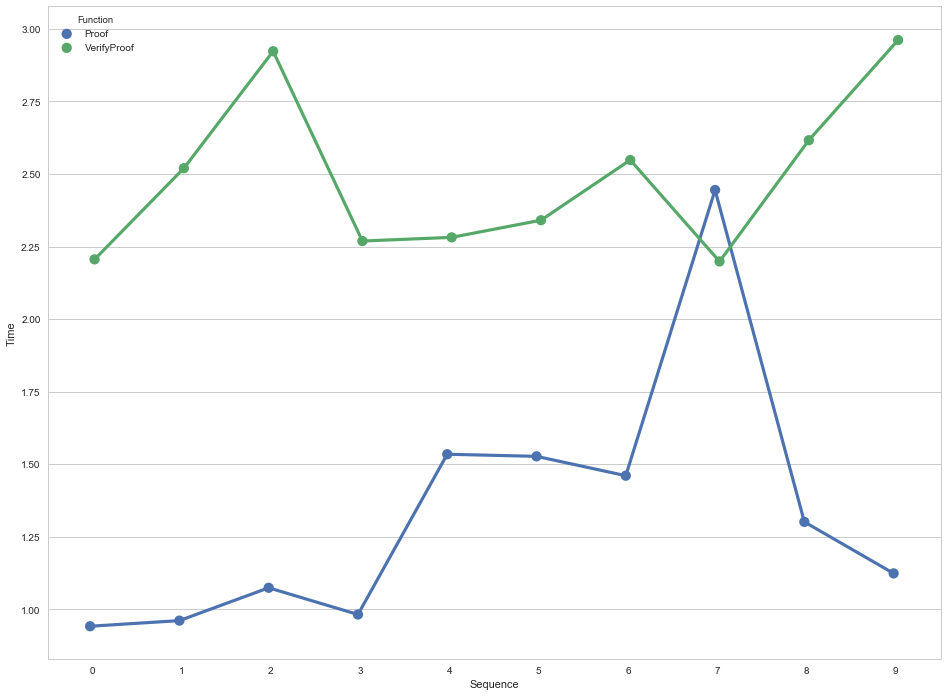

In [117]:
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")
ax = sns.pointplot(x="Sequence", y="Time", hue="Function", # col="TargetType", #col="isOccluded",
                   data=alldata, dodge=True, estimator=np.median, capsize=.1)

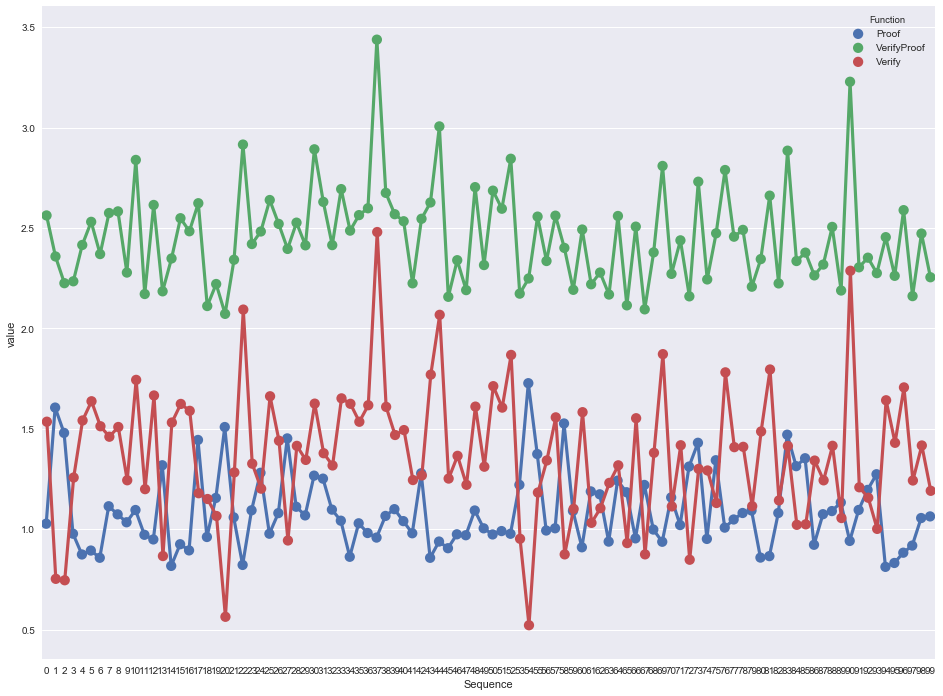

In [106]:
plt.figure(figsize=(16, 12))
ax = sns.pointplot(x="Sequence", y="value", hue="Function",# col="TargetType", #col="isOccluded",
                   data=meltdata, dodge=True, estimator=np.median, capsize=.1)

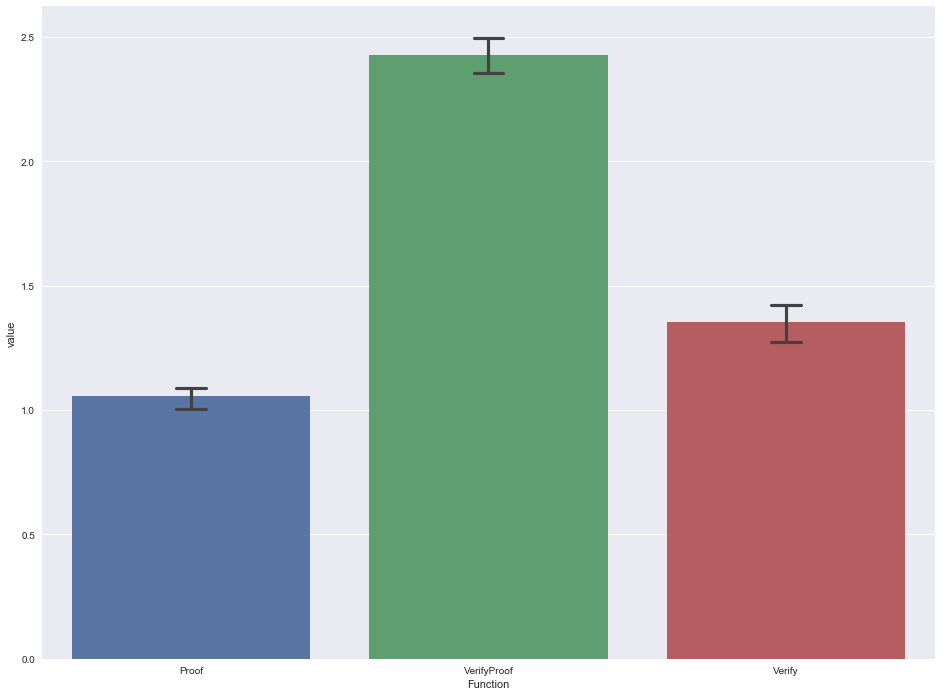

In [122]:
plt.figure(figsize=(16, 12))
ax = sns.barplot(x="Function", y="value", #hue="isOccluded",# col="TargetType", #col="isOccluded",
                   data=meltdata, dodge=True, estimator=np.median, capsize=.1)

In [104]:
pd.melt(pivotdata, id_vars=["Sequence"])

,Sequence,Function,value
0,0,Proof,1.027271
1,1,Proof,1.605637
2,2,Proof,1.479525
3,3,Proof,0.977371
4,4,Proof,0.874021
5,5,Proof,0.893554
6,6,Proof,0.857558
7,7,Proof,1.114228
8,8,Proof,1.073844
9,9,Proof,1.034421


# All Data with Security params

In [119]:
alldata = pd.read_csv(distalfile, skipinitialspace=True)
# alldata = alldata.reset_index()

[<matplotlib.text.Text at 0x11d0aa780>, <matplotlib.text.Text at 0x11bf97160>]

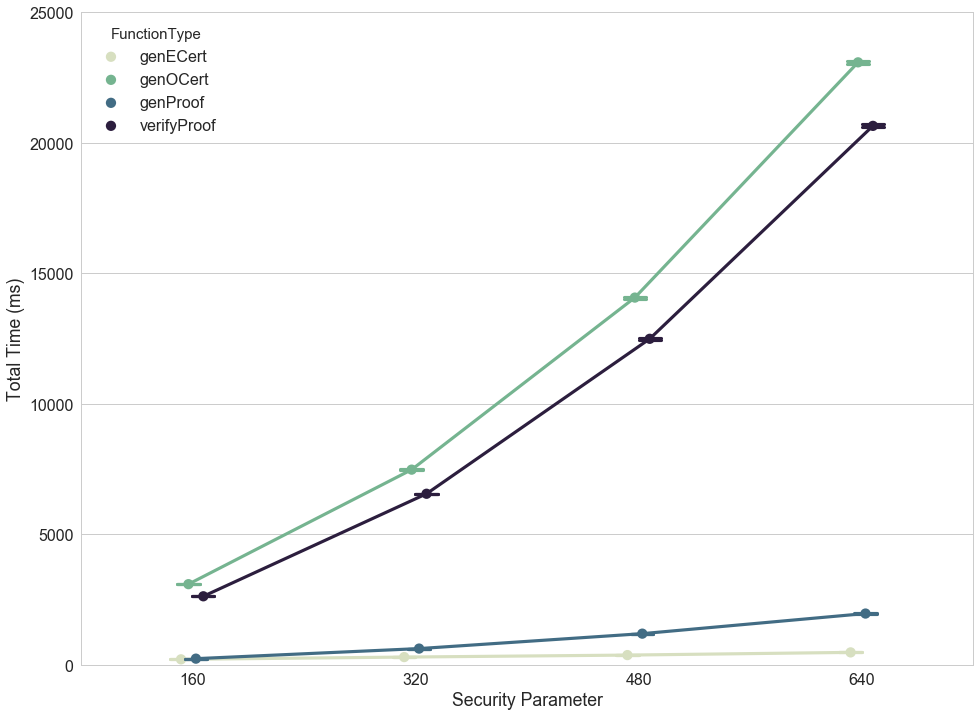

In [134]:
plt.figure(figsize=(16, 12))
sns.set(font_scale=1.6)
sns.set_style("whitegrid")
ax = sns.pointplot(x="SecurityParam", y="TotalTime", hue="FunctionType",
                   palette=sns.cubehelix_palette(4, start=0.5, rot=-.75),
                   data=alldata, dodge=True, estimator=np.median, capsize=.1)
ax.set_ylim(0, 25000)
ax.set(xlabel='Security Parameter', ylabel='Total Time (ms)')
# plt.setp(ax.get_legend().get_texts(), fontsize='15') 
# plt.setp(ax.get_legend(), fontsize='22') 


In [136]:
ax.get_figure().savefig("../Figures/SecurityParam_Comparison.pdf")


In [107]:
alldata["TotalTime"]

0         289.198109
1         239.445150
2         243.041745
3         235.095556
4         254.454788
5         227.264227
6         243.706750
7         203.912173
8         211.461539
9         217.055244
10        235.135807
11        211.145217
12        201.917360
13        207.826089
14        209.899608
15        208.363446
16        201.621015
17        205.843262
18        208.248085
19        210.588383
20        192.399850
21        211.987310
22        206.793126
23        214.857474
24        212.337590
25        200.082057
26        236.708026
27        223.165632
28        209.046329
29        189.612186
            ...     
1570    20636.585144
1571    20534.267814
1572    21767.336394
1573    22001.276451
1574    20908.919145
1575    20552.734837
1576    20662.512235
1577    20565.295130
1578    20560.377193
1579    20511.466686
1580    20493.437560
1581    20831.623035
1582    20597.724205
1583    20606.407852
1584    20762.164591
1585    20825.002846
1586    20561

AttributeError: 'DataFrame' object has no attribute 'Iteration'